In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import autograd
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

from torchsummary import summary
from torchvision.utils import save_image
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataroot = "/content/drive/My Drive/Colab Notebooks/w210/WGAN_gp-tamuraphys/data/Tomato/"
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 224

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [4]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

In [5]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

https://github.com/pytorch/examples/issues/70

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 7, 1, 0, bias=False), #nz チャンネル * 1*1 テンソルを ngf*16 * (2*2)のテンソルに変更
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True), #in-place option = True?メモリの節約？
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            # state size. (ngf*8) x 14 x 14
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*4) x 28 x 28
            nn.ConvTranspose2d( ngf * 2, ngf * 1, 4, 4, 0, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.ReLU(True),
            # state size. (ngf*2) x 112 x 112
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 224 x 224
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)
#summary(netG, input_size=(128, 128, 3))

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 224 x 224
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 112 x 112
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 56 x 56
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 28 x 28
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 14 x 14
            nn.Conv2d(ndf * 8, ndf * 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 16),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*16) x 7 x 7
            nn.Conv2d(ndf * 16, 1, 7, 1, 0, bias=False), #チャンネル数1, 1*1のテンソル
            #nn.Sigmoid() #sigmoidで[0, 1]の範囲に収め, 確率にする
            # state size. 1
        )

    def forward(self, input):
        return self.main(input) #feedforward


# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [8]:
def compute_gradient_penalty(real_images, fake_images):
  B_size = real_images.size(0)
  eta = torch.FloatTensor(B_size,1,1,1).uniform_(0,1).to(device) #(batch_size, 1, 1, 1)の形の乱数によるtensorを作る
  eta = eta.expand(B_size, real_images.size(1), real_images.size(2), real_images.size(3)) #expandにより (batch_size, 1, 1, 1) -> (batch_size, real_images.size(1), real_images.size(2), real_images.size(3))に複製・拡大する
  interpolated = eta * real_images + ((1 - eta) * fake_images) #etaによるreal imageとfake imageの内分点をとる
  interpolated = torch.tensor(interpolated, requires_grad=True) #requires_grad特性をTrueにする
  prob_interpolated = netD(interpolated) #descriminator(critic)によるinterpolatedのoutputを計算
  gradients = autograd.grad(outputs=prob_interpolated, #outputはprob_interpolated, inputはinterpolatedとして微分を計算する
                            inputs=interpolated,
                            grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                            create_graph=True,
                            retain_graph=True)[0] #これはinputのテンソルを1つ固定して, それで微分した後にoutputに関して和を取るのと一緒
  grad_penalty = ((gradients.norm(2, dim=(1,2,3)) - 1) ** 2).mean() #dim=(1,2,3)に関して添字が走るベクトルだと思ってL2normを計算.この場合,batch_size分のnormが得られるのでそれに関して(-1と２乗をした後に)平均をとる
  return grad_penalty

In [9]:
# Number of training epochs
num_epochs = 1000

# Number of generator iterations
g_iters = 2

# Parameter for the gradient penalty
lambda_gp = 10 
# Initialize BCELoss function
#criterion = nn.BCELoss() #binary cross entropy(-ylogx - (1-y)log(1-x)) の最小化でオッケー

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device) #latent space vector

# Establish convention for real and fake labels during training 
real_label = 1. #realなら1 
fake_label = 0. #fakeなら0

# Setup Adam optimizers for both G and D
lrD = 0.0002
lrG = 0.00022
optimizerD = optim.Adam(netD.parameters(), lr=lrD, betas=(beta1, 0.999)) #netDのパラメータだけ更新
optimizerG = optim.Adam(netG.parameters(), lr=lrG, betas=(beta1, 0.999)) #netGのパラメータだけ更新

In [10]:
import datetime
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
  # For each batch in the dataloader
  for i, data in enumerate(dataloader, 0): #enumerate(dataloader, 0)とは0から始めるindexを付与しながら取ってくる
    ############################
    # (1) Update D network: minimize -E(D(x)) + E(D(G(z))) + lambda_gp*E(|grad(D(y)) - 1|^2)
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device) #data[0] はmini batch内の画像のテンソル全て
    b_size = real_cpu.size(0) #minibatchのサイズ
    # Forward pass real batch through D
    Dreal = netD(real_cpu).view(-1) #1列に直すために.view(-1)
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device) #(b_size, nz, 1, 1)の乱数を作る
    # Generate fake image batch with G
    fake = netG(noise) 
    # Calculate the critic for all fake batch
    Dfake = netD(fake.detach()).view(-1) #detachをすることで, 計算グラフから切り離されたコピーを作る
    # Calculate loss on all batch
    errD = -Dreal.mean() + Dfake.mean() + lambda_gp * compute_gradient_penalty(real_images=real_cpu, fake_images=fake) #gradient penaltyを追加したloss function
    errD.backward() #バックワード (errD_realのgradientを計算)
    D_x = Dreal.mean().item() #D(real data)の平均
    D_G_z1 = Dfake.mean().item() #D(G(z))の平均(0の方がDは仕事をしている)
    # Update D
    optimizerD.step()
    netG.zero_grad() #以降のために, 一応ここでGのgradientを0に初期化しておく
    ############################
    # (2) Update G network: minimize -E(C(G(z)))
    ###########################
    for j in range(g_iters):
      netG.zero_grad()
      fake = netG(noise) #改めてfake画像を生成(その必要は本当にあるのか?)
      # Since we just updated D, perform another forward pass of all-fake batch through D
      output = netD(fake).view(-1) #D(G(z))
      # Calculate G's loss based on this output
      errG = -output.mean() #Gに対するloss function
      # Calculate gradients for G
      errG.backward() #微分
      D_G_z2 = output.mean().item() #平均
      # Update G
      optimizerG.step() #パラメータの更新



    # Output training stats
    if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
              % (epoch, num_epochs, i, len(dataloader),
                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        print('{}'.format(datetime.datetime.now()))
    
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    
    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
        img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        
    iters += 1

Starting Training Loop...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


[0/1000][0/6]	Loss_D: 7299.2471	Loss_G: -21.5011	D(x): -2.3066	D(G(z)): 0.3073 / 21.5011
2021-02-27 23:38:36.753179
[1/1000][0/6]	Loss_D: 79.6438	Loss_G: -63.5795	D(x): 2.0566	D(G(z)): 56.4546 / 63.5795
2021-02-27 23:39:12.654715
[2/1000][0/6]	Loss_D: 82.5371	Loss_G: -78.9397	D(x): 9.9525	D(G(z)): 84.6815 / 78.9397
2021-02-27 23:39:23.861516
[3/1000][0/6]	Loss_D: 53.2437	Loss_G: -54.6074	D(x): 17.9086	D(G(z)): 63.2192 / 54.6074
2021-02-27 23:39:35.319716
[4/1000][0/6]	Loss_D: 31.3874	Loss_G: -40.3281	D(x): 22.3302	D(G(z)): 48.6069 / 40.3281
2021-02-27 23:39:47.240206
[5/1000][0/6]	Loss_D: 24.2829	Loss_G: -35.6834	D(x): 25.3070	D(G(z)): 44.7730 / 35.6834
2021-02-27 23:39:59.578680
[6/1000][0/6]	Loss_D: 23.0049	Loss_G: -40.4903	D(x): 26.1998	D(G(z)): 45.8646 / 40.4903
2021-02-27 23:40:11.813298
[7/1000][0/6]	Loss_D: 30.4397	Loss_G: -46.6066	D(x): 23.4757	D(G(z)): 51.5643 / 46.6066
2021-02-27 23:40:23.745222
[8/1000][0/6]	Loss_D: 23.8590	Loss_G: -38.2057	D(x): 22.0183	D(G(z)): 44.3086 / 3

In [11]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

Output hidden; open in https://colab.research.google.com to view.

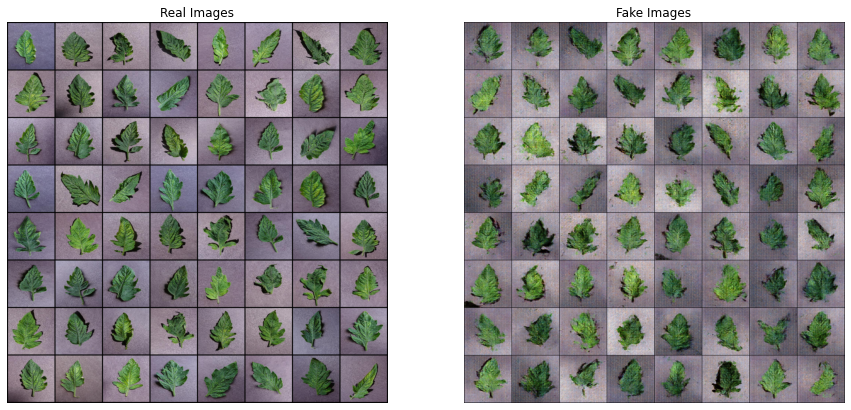

In [12]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

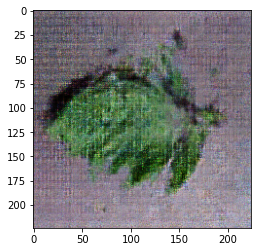

In [13]:
plt.imshow(np.transpose(0.5*(fake[0]+1)))

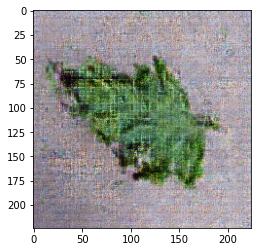

In [14]:
plt.imshow(np.transpose(0.5*(fake[9]+1)))

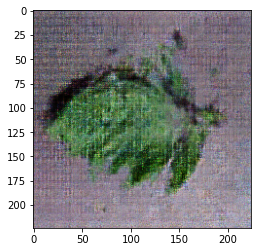

In [15]:
#
img0 = np.transpose(0.5*(fake[0]+1))
img1 = img0.numpy()
plt.imshow(img0)

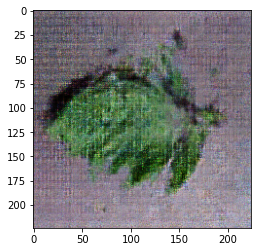

In [16]:
plt.imshow(img1)

In [ ]:
print((real_batch[0][1]), len(real_batch[0]))
plt.imshow(np.transpose(0.5*(real_batch[0][63]+1)))

In [17]:
def save_img_results(data_img, fake, epoch, image_dir):
    num = cfg.VIS_COUNT
    fake = fake[0:num]
    # data_img is changed to [0,1]
    if data_img is not None:
        data_img = data_img[0:num]
        vutils.save_image(
            data_img, '%s/real_samples.png' % image_dir,
            normalize=True)
        # fake.data is still [-1, 1]
        vutils.save_image(
            fake.data, '%s/fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True)
    else:
        vutils.save_image(
            fake.data, '%s/lr_fake_samples_epoch_%03d.png' %
            (image_dir, epoch), normalize=True) 

In [18]:
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    #plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.imshow(tensor.numpy())
    plt.show()

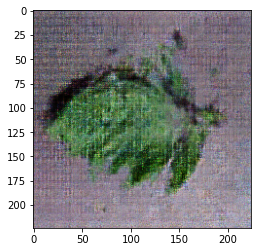

In [19]:
plot_image(img0)

In [20]:
pil_img = Image.fromarray(im)
print(pil_img.mode)
# RGB

pil_img.save('data/temp/lena_save_pillow.jpg')

NameError: ignored

In [ ]:
from PIL import Image
im = Image.fromarray(img0)
im.save("your_file.jpeg")

In [ ]:
print(type(img0), img0.shape)
plt.imshow(img0)
vutils.save_image(img0.numpy(), 'test.png')

In [ ]:
from torchvision.utils import save_image
import torch
import torchvision

tensor= torch.rand(2, 3, 400, 711) 

img1 = img0
save_image(img1, '/content/drive/My Drive/Colab Notebooks/w210/WGAN_gp-tamuraphys/data/img1.png')
plt.imshow(img0)

In [ ]:
print((real_batch[0][1]), len(real_batch[0]))
plt.imshow(np.transpose(0.5*(real_batch[0][63]+1)))

In [40]:
plt.savefig('test.png', img0.numpy())

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [20]:
#images.shape #torch.Size([64,3,28,28])
#img1 = images[0] #torch.Size([3,28,28]
# img1 = img1.numpy() # TypeError: tensor or list of tensors expected, got <class 'numpy.ndarray'>
save_image(img0, 'img1.png')

TypeError: ignored

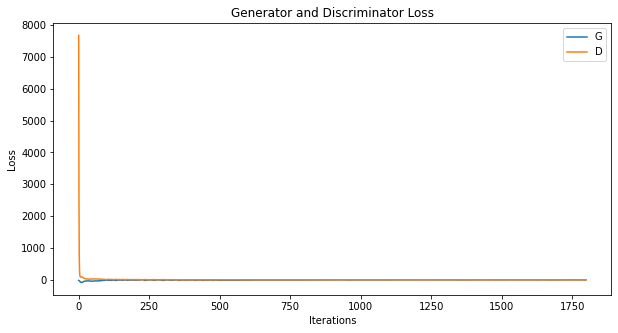

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')
im_batch_size = 50
n_images=10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, 100, 1, 1, device=device)
    gen_images = netG(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch+i_image:05d}.png'))


import shutil
shutil.make_archive('images', 'zip', '../output_images')

In [ ]:
for i in range(10):
    plt.imshow(images[i])
    plt.show()